# IMPORTING ALL NECESSARY LIBRARIES

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 
import cv2

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import random



# Importing the MRI images 





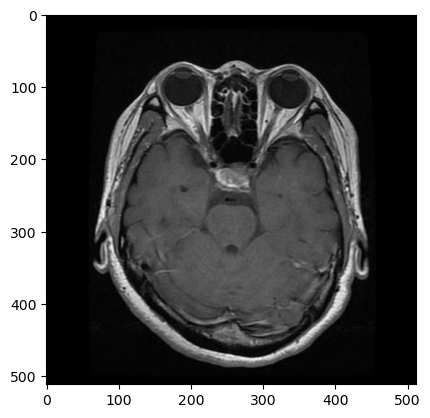

In [114]:
path1 = r"D:\PROJECT\BT"                        # selecting the drive 
cate = ['glioma' , 'meningioma' , 'notumor' , 'pituitary']

for i in cate:
    folders = os.path.join(path1,i)
    for image in os.listdir(folders):
        image_path = os.path.join(folders, image)
        image_array = cv2.imread(image_path)      # using the cv2, we are reading the images
        plt.imshow(image_array)      
        break

# EDA DATA PRE PROCESSING

In [122]:
# Finding the duplicate images and deleting it

seen = {}                    # creating an empty dict
deleted_count = 0

for category in cate:
    folder = os.path.join(path1, category)
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        
        try:
            with open(image_path, 'rb') as f:
                content = f.read()

            if content in seen:
                os.remove(image_path)
                deleted_count += 1
                print(f"Deleted duplicate: {image_path}")
            else:
                seen[content] = image_path

        except Exception as e:
            print(f"Error reading/deleting {image_path}: {e}")

print(f"\nTotal duplicate images deleted: {deleted_count}")

Deleted duplicate: D:\PROJECT\BT\glioma\gg (184).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (2).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (272).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (294).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (336).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (649).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (763).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\gg (86).jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0000.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0001.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0002.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0003.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0004.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0005.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0006.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0007.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0008.jpg
Deleted duplicate: D:\PROJECT\BT\glioma\Te-glTr_0009.jpg
Deleted d

# CHECKING THE DATA DISTRIBUTION

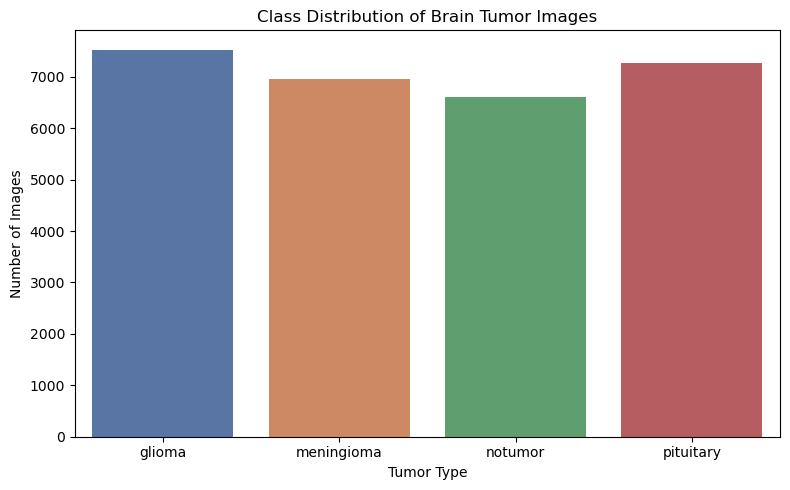

In [127]:
cat_path = path1
class_counts = {i: len(os.listdir(os.path.join(cat_path, i))) for i in cate}

plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()),palette="deep")
plt.title("Class Distribution of Brain Tumor Images")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


# DATA AUGMENTATION

In [133]:
# Since there are various images and the shapes are different, we need to reshape it same sizes

image_size = 64  

input_image = [] 
for i in cate:
    folders = os.path.join(path1,i)
    label = cate.index(i)
    for image in os.listdir(folders):
        image_path = os.path.join(folders, image)
        image_array = cv2.imread(image_path)     
        image_array = cv2.resize(image_array, (image_size , image_size))
        image_array = cv2.warpAffine(cv2.cvtColor(np.clip(cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV).astype("float32") * 
                                                          [1,1,1.3], 0, 255).astype("uint8"), cv2.COLOR_HSV2BGR),
                                     cv2.getRotationMatrix2D((image_size//2, image_size//2), 10, 1.0), 
                                     (image_size, image_size))  # Brightness and rotation augmentation 

        image_array = image_array / 255.0    # Normalizing the pixel values to [0,1]

        input_image.append([image_array , label])    

In [134]:
print("Total images loaded:", len(input_image))

Total images loaded: 28364


In [137]:
# random shuffling the images
random.shuffle(input_image)


In [142]:
print(28364 * 0.8)
train = input_image[0:22691]      
test = input_image[22691:28364]          # Since the total image is 28364, we are splitting it into train and test by 20% split

22691.2


In [144]:
x_train = []
y_train = []

for x_values, labels in train:
    x_train.append(x_values)
    y_train.append(labels)
    

In [146]:
x_test = []
y_test = []

for x_values, labels in test:
    x_test.append(x_values)
    y_test.append(labels)

In [148]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [149]:
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation='relu')) 
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))  # adding dropout

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())     
model.add(Dense(256, activation='relu', input_shape = x_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))    

# from tensorflow.keras.optimizers import Adam
# adam = Adam(learning_rate = 0.02)
 
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])  

In [150]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [151]:
df1 = model.fit(x_train, y_train, epochs = 15, validation_split=.2, batch_size = 128, callbacks=[early_stop])  
# saving the model as df1 inorder to plot training & validation Accuracy and Loss

Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 104s 659ms/step - accuracy: 0.4498 - loss: 1.1696 - val_accuracy: 0.6880 - val_loss: 0.7154
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 49s 347ms/step - accuracy: 0.7457 - loss: 0.6540 - val_accuracy: 0.8306 - val_loss: 0.4384
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 50s 352ms/step - accuracy: 0.8179 - loss: 0.4781 - val_accuracy: 0.8771 - val_loss: 0.3131
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 48s 339ms/step - accuracy: 0.8672 - loss: 0.3586 - val_accuracy: 0.8980 - val_loss: 0.2720
Epoch 5/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 327ms/step - accuracy: 0.8913 - loss: 0.2909 - val_accuracy: 0.9169 - val_loss: 0.2194
Epoch 6/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 325ms/step - accuracy: 0.9028 - loss: 0.2528 - val_accuracy: 0.9352 - val_loss: 0.1783
Epoch 7/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - accuracy: 0.9239 - loss: 0.2037 - val_accuracy: 0.9456 - val_loss: 0.1658
Epoch 8/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 46s 327ms/step - accuracy: 0.9309 - loss: 

In [152]:
pred = model.predict(x_test)
pred_classes = pred.argmax(axis=1)   

178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


# MODEL EVALUATION ON TEST DATA

In [153]:
from sklearn.metrics import confusion_matrix, classification_report
tab=confusion_matrix(y_test, pred_classes)
print(tab)
print('---------------------------------------')
print(classification_report(y_test, pred_classes))
print('accuracy in decimals',tab.diagonal().sum() / tab.sum()*100)

[[1406   76    0    8]
 [  20 1362   14   12]
 [   1   15 1306    6]
 [   2   14    1 1430]]
---------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1490
           1       0.93      0.97      0.95      1408
           2       0.99      0.98      0.99      1328
           3       0.98      0.99      0.99      1447

    accuracy                           0.97      5673
   macro avg       0.97      0.97      0.97      5673
weighted avg       0.97      0.97      0.97      5673

accuracy in decimals 97.02097655561431


# Model Training and Validation Performance



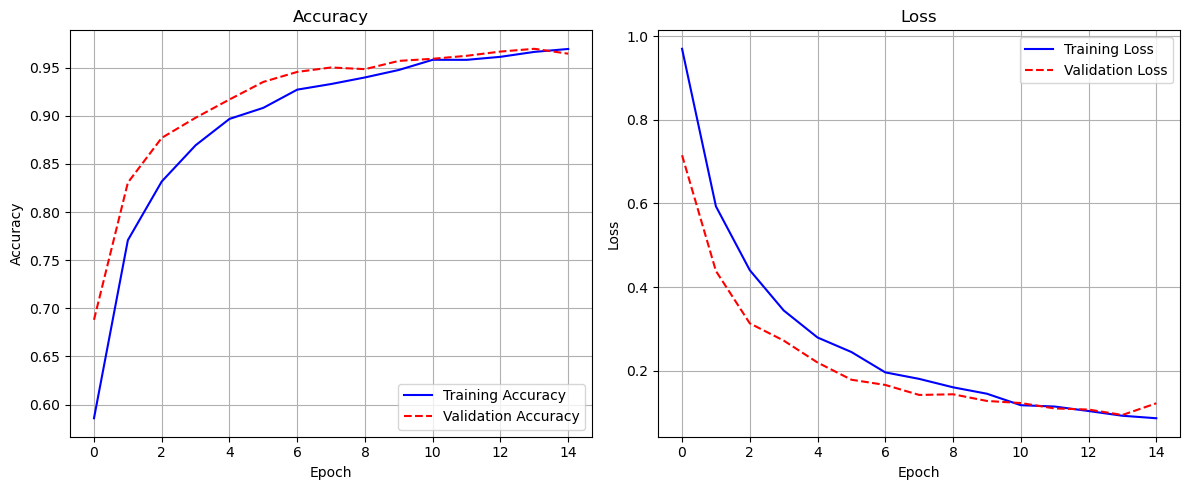

In [156]:
# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(df1.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(df1.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(df1.history['loss'], label='Training Loss', color='blue')
plt.plot(df1.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# SAVING THE MODEL

In [166]:
model.save("brain_tumor_model.h5")

In [168]:
pwd

'C:\\Users\\Amaljith P'